# Pointwise R. - Dens Local F.
## RF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# https://towardsdatascience.com/gowers-distance-for-mixed-categorical-and-numerical-data-799fedd1080c/
import gower

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()
df_final = df_final.dropna()


# Marking categorical columns
categorical_cols = ['DayOfWeekNum', 'WeekOfYear', 'Month', 'IsWeekend']
for col in categorical_cols:
    df_final[col] = df_final[col].astype('object')
df_final.dtypes

Date             object
DayOfWeekNum     object
WeekOfYear       object
Month            object
IsWeekend        object
IsHoliday         int64
NUMBER_INT        int64
temp_max        float64
temp_min        float64
humidity_max    float64
dtype: object

In [4]:
# Simulate what gower_matrix does internally
is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
cat_features_mask = is_number(df_final.dtypes)
print(cat_features_mask)

[ True  True  True  True  True False False False False False]


In [5]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)


df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)


print(f"Training set size: {df_train.count()} rows")
print(f"Validation set size: {df_val.count()} rows")
print(f"Training set date range: {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"Validation set date range: {df_val['Date'].min()} to {df_val['Date'].max()}")

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

Training set size: Date            1461
DayOfWeekNum    1461
WeekOfYear      1461
Month           1461
IsWeekend       1461
IsHoliday       1461
NUMBER_INT      1461
temp_max        1461
temp_min        1461
humidity_max    1461
dtype: int64 rows
Validation set size: Date            360
DayOfWeekNum    360
WeekOfYear      360
Month           360
IsWeekend       360
IsHoliday       360
NUMBER_INT      360
temp_max        360
temp_min        360
humidity_max    360
dtype: int64 rows
Training set date range: 2015-01-01 00:00:00 to 2018-12-31 00:00:00
Validation set date range: 2019-01-01 00:00:00 to 2019-12-26 00:00:00


In [6]:
results = []

In [7]:

best_rf_model_base = RandomForestRegressor(
    n_estimators=20,
    max_depth=6,
    min_samples_split=16,
    random_state=9
)

best_rf_model_base.fit(X_train, y_train)

y_pred = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mape_val = mape(y_val, y_pred)
smape_val = smape(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

results.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'sMAPE': smape_val,
    'R2': r2,
    'Correlation': corr
})

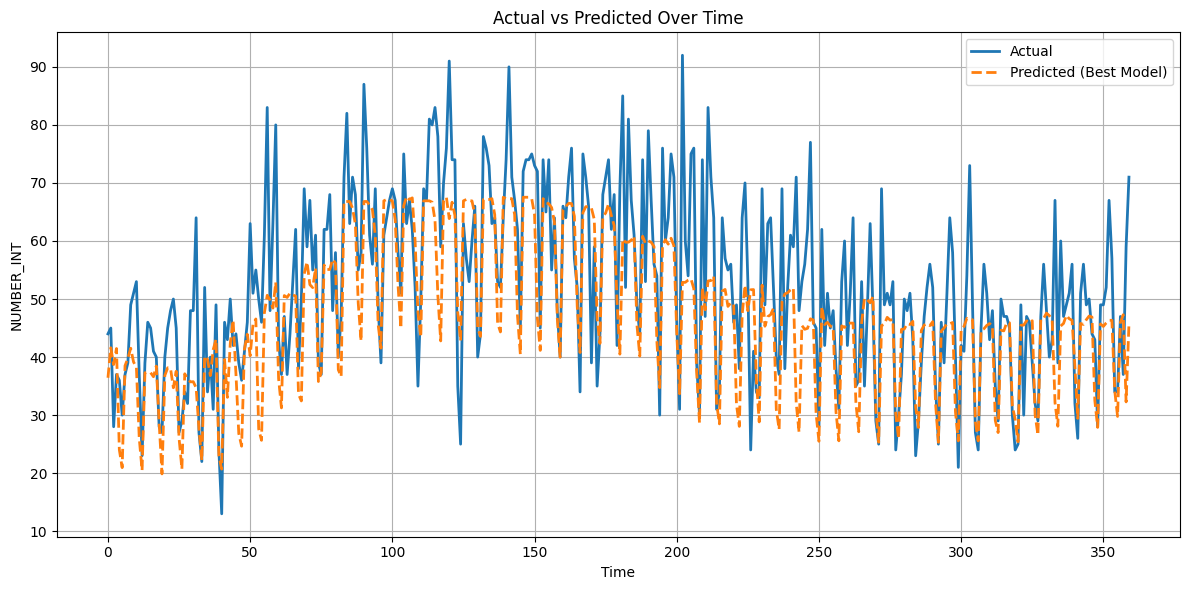

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
results

[{'MSE': 118.46528724070834,
  'RMSE': 10.88417600191711,
  'MAE': 8.106401203057157,
  'MAPE': 15.438129557090782,
  'sMAPE': 16.428265889465187,
  'R2': 0.5044579535395584,
  'Correlation': 0.7832618681004934}]

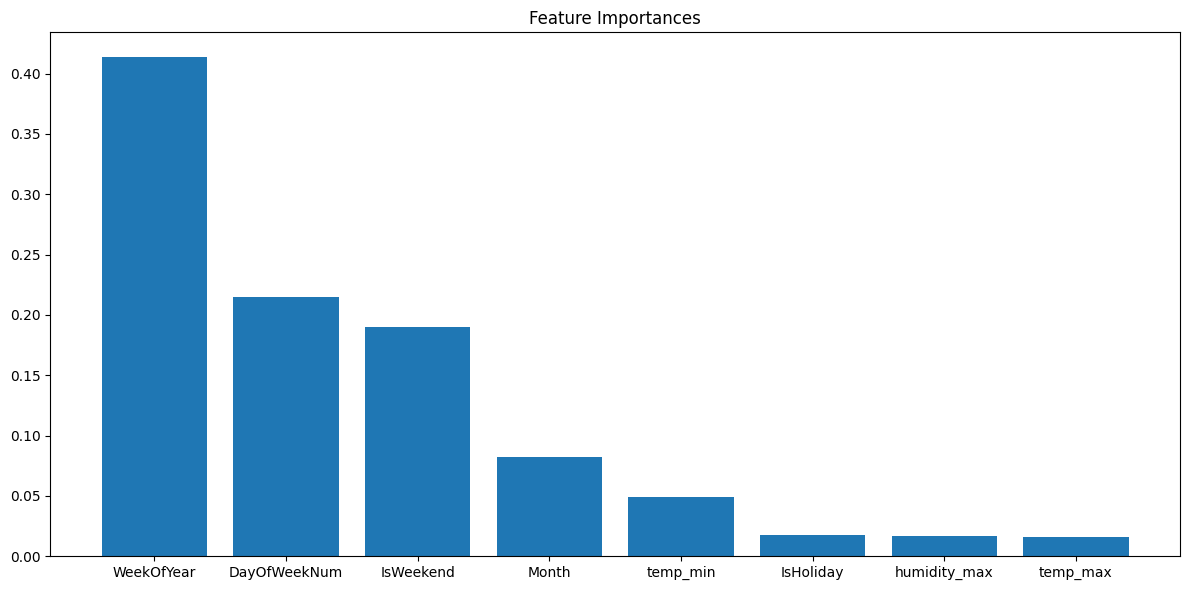

In [10]:
importances = best_rf_model_base.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices])
plt.tight_layout()
plt.show()

In [11]:
importances[indices]

array([0.41355776, 0.21510835, 0.19030288, 0.08203985, 0.04886889,
       0.01772122, 0.01689043, 0.01551062])

# Pointwise Density + Local Fit

In [12]:
# Scaler

# No scaller needed for Gower distance

# scaler = MinMaxScaler()
#scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
# X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

In [13]:
X_train.dtypes

DayOfWeekNum     object
WeekOfYear       object
Month            object
IsWeekend        object
IsHoliday         int64
temp_max        float64
temp_min        float64
humidity_max    float64
dtype: object

In [14]:
# TODO: Select only the most important features based on the importances

distance_features = ['DayOfWeekNum', 'WeekOfYear', 'IsWeekend', 'Month']
# distance_features = ['WeekOfYear', 'DayOfWeekNum]

X_train_dist = X_train[distance_features].copy()
X_val_dist = X_val[distance_features].copy()



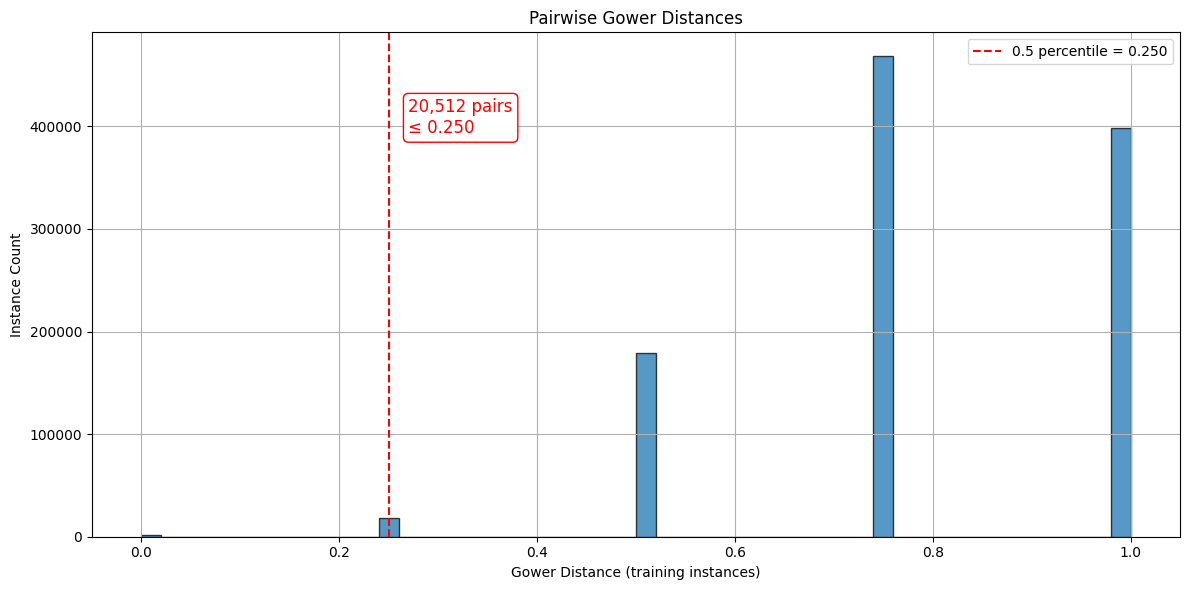

In [15]:
train_distance_matrix = gower.gower_matrix(X_train_dist)

# Get upper triangle of the symmetric matrix (excluding diagonal)
i_upper = np.triu_indices_from(train_distance_matrix, k=1)
pairwise_distances_train = train_distance_matrix[i_upper]


percentile_number = 0.5
selected_percentile = np.percentile(pairwise_distances_train, percentile_number)
count_below_percentile = np.sum(pairwise_distances_train <= selected_percentile)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(pairwise_distances_train, bins=50, edgecolor='black', alpha=0.75)
plt.axvline(selected_percentile, color='red', linestyle='--', label=f'{percentile_number} percentile = {selected_percentile:.3f}')
plt.text(selected_percentile + 0.02, plt.ylim()[1]*0.8,
         f'{count_below_percentile:,} pairs\n≤ {selected_percentile:.3f}',
         color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.xlabel("Gower Distance (training instances)")
plt.ylabel("Instance Count")
plt.title("Pairwise Gower Distances")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
within_threshold = (train_distance_matrix <= selected_percentile)

# Exclude self-comparison (on the diagonal)
np.fill_diagonal(within_threshold, False)

# Count neighbors within threshold for each instance
neighbors_within_threshold = np.sum(within_threshold, axis=1)

k_max = int(np.mean(neighbors_within_threshold))
k_max


28

In [17]:
# Reliability 
def compute_density(distances_row, threshold, min_cluster_units):
    count = np.sum(distances_row <= threshold)
    return min(count, min_cluster_units) / min_cluster_units


def compute_data_agreement(distances_row, y_pred_new, y_train, min_cluster_units, tolerance, threshold):
    # Select neighbors within threshold
    candidate_indices = np.where(distances_row <= threshold)[0]
    count = len(candidate_indices)
    if count == 0:
        return 0.0

    # Sort by distance
    sorted_indices = candidate_indices[np.argsort(distances_row[candidate_indices])]
    selected_indices = sorted_indices[:min(count, min_cluster_units)]

    neighbor_targets = y_train.iloc[selected_indices]
    agreement_count = np.sum(np.abs(neighbor_targets - y_pred_new) < tolerance)

    return agreement_count / min(count, min_cluster_units)


def compute_ml_agreement(distances_row, y_pred_new, X_train, model, min_cluster_units, tolerance, threshold):
    candidate_indices = np.where(distances_row <= threshold)[0]
    count = len(candidate_indices)
    if count == 0:
        return 0.0

    sorted_indices = candidate_indices[np.argsort(distances_row[candidate_indices])]
    selected_indices = sorted_indices[:min(count, min_cluster_units)]

    X_neighbors_full = X_train.iloc[selected_indices]
    neighbor_preds = model.predict(X_neighbors_full)
    agreement_count = np.sum(np.abs(neighbor_preds - y_pred_new) < tolerance)

    return agreement_count / min(count, min_cluster_units)


def compute_reliability_score_fast(distances_row, y_pred_new, X_train, y_train, model, threshold, min_cluster_units, tolerance):
    density = compute_density(distances_row, threshold, min_cluster_units)
    data_agreement = compute_data_agreement(distances_row, y_pred_new, y_train, min_cluster_units, tolerance, threshold)
    ml_agreement = compute_ml_agreement(distances_row, y_pred_new, X_train, model, min_cluster_units, tolerance, threshold)
    return density * data_agreement * ml_agreement


In [18]:
# Setup
final_tolerance = 8
final_min_cluster_uni = 28
final_threshold = 0.250

In [19]:
val_to_train_distances = gower.gower_matrix(X_val_dist,X_train_dist)


reliability_scores = []

for i in range(len(X_val)):
    distances_row = val_to_train_distances[i]
    y_pred_new = y_pred[i]
    
    score = compute_reliability_score_fast(
        distances_row,
        y_pred_new,
        X_train,
        y_train,
        best_rf_model_base,
        threshold=final_threshold,
        min_cluster_units=final_min_cluster_uni,
        tolerance=final_tolerance
    )
    
    reliability_scores.append(score)

# Add reliability scores to df_val
df_val['Reliability'] = reliability_scores


In [20]:
i = 0
distances_row = val_to_train_distances[i]
nearest_indices = np.argsort(distances_row)[:5]

print("Val instance:", X_val.iloc[i].to_dict())
print("Nearest train indices:", nearest_indices)
print("Corresponding distances:", distances_row[nearest_indices])
print("Nearest train samples:")
print(X_train.iloc[nearest_indices])

Val instance: {'DayOfWeekNum': 1, 'WeekOfYear': 1, 'Month': 1, 'IsWeekend': 0, 'IsHoliday': 1, 'temp_max': 27.9, 'temp_min': 19.2, 'humidity_max': 92.0}
Nearest train indices: [ 733 1097  369    0 1104]
Corresponding distances: [0.   0.   0.   0.25 0.25]
Nearest train samples:
     DayOfWeekNum WeekOfYear Month IsWeekend  IsHoliday  temp_max  temp_min  \
733             1          1     1         0          0      33.0      20.6   
1097            1          1     1         0          0      29.8      19.4   
369             1          1     1         0          0      27.5      17.9   
0               3          1     1         0          1      33.9      20.6   
1104            1          2     1         0          0      29.2      19.7   

      humidity_max  
733           79.0  
1097          92.0  
369           92.0  
0             89.0  
1104          73.0  


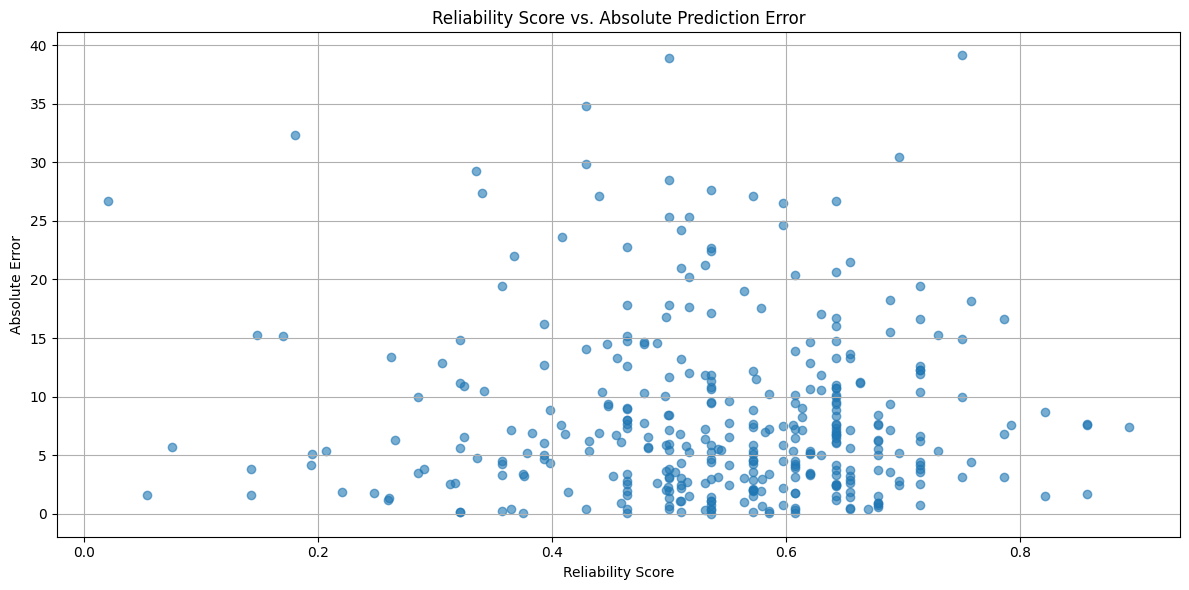

In [21]:
# Absolute prediction error
errors = np.abs(y_val.values - y_pred)

plt.figure(figsize=(12, 6))
plt.scatter(df_val['Reliability'], errors, alpha=0.6)
plt.xlabel("Reliability Score")
plt.ylabel("Absolute Error")
plt.title("Reliability Score vs. Absolute Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_8255/2153609289.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby("reliability_bin")


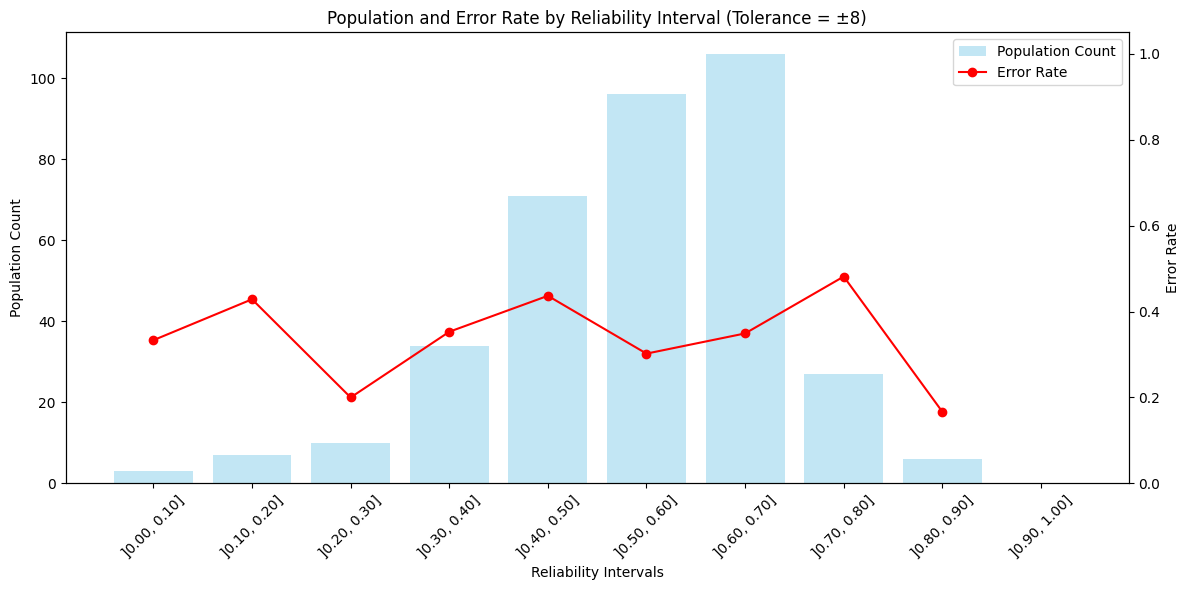

In [22]:
tolerance = final_tolerance

df_plot = df_val.copy()
df_plot["y_true"] = y_val.values
df_plot["y_pred"] = y_pred
df_plot["abs_error"] = np.abs(df_plot["y_true"] - df_plot["y_pred"])

df_plot["correct"] = df_plot["abs_error"] <= tolerance

# Define reliability bins
bins = np.linspace(0, 1, 11)  # 0.0 to 1.0 in steps of 0.1
labels = [f"]{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(bins)-1)]
df_plot["reliability_bin"] = pd.cut(df_plot["Reliability"], bins=bins, labels=labels, include_lowest=True)

# Group by reliability bin
grouped = df_plot.groupby("reliability_bin")
pop_count = grouped.size()
correct_count = grouped["correct"].sum()
error_rate = 1 - (correct_count / pop_count)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pop_count.index, pop_count.values, alpha=0.5, color='skyblue', label="Population Count")
ax1.set_ylabel("Population Count", color='black')
ax1.set_xlabel("Reliability Intervals")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(error_rate.index, error_rate.values, marker='o', color='red', label="Error Rate")
ax2.set_ylabel("Error Rate")
ax2.set_ylim(0, 1.05)

plt.title(f"Population and Error Rate by Reliability Interval (Tolerance = ±{tolerance})")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()
